# **Vision Transformer for Nail Melanoma Classification**

## **1. Setup**

In [1]:
%pip install einops 


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip list

Package                  Version
------------------------ ------------
absl-py                  2.1.0
asttokens                2.4.1
astunparse               1.6.3
certifi                  2024.8.30
charset-normalizer       3.4.0
comm                     0.2.2
contourpy                1.3.1
cycler                   0.12.1
debugpy                  1.8.9
decorator                5.1.1
einops                   0.8.0
executing                2.1.0
filelock                 3.13.1
flatbuffers              24.3.25
fonttools                4.55.0
fsspec                   2024.2.0
gast                     0.6.0
google-pasta             0.2.0
grpcio                   1.68.0
h5py                     3.12.1
idna                     3.10
ipykernel                6.29.5
ipython                  8.29.0
jedi                     0.19.2
Jinja2                   3.1.3
jupyter_client           8.6.3
jupyter_core             5.7.2
keras                    3.6.0
kiwisolver               1.4.7
libclang      

## **2. Image Patching**

In [4]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

Total images in dataset: 4000
Sample image shape: torch.Size([3, 144, 144])


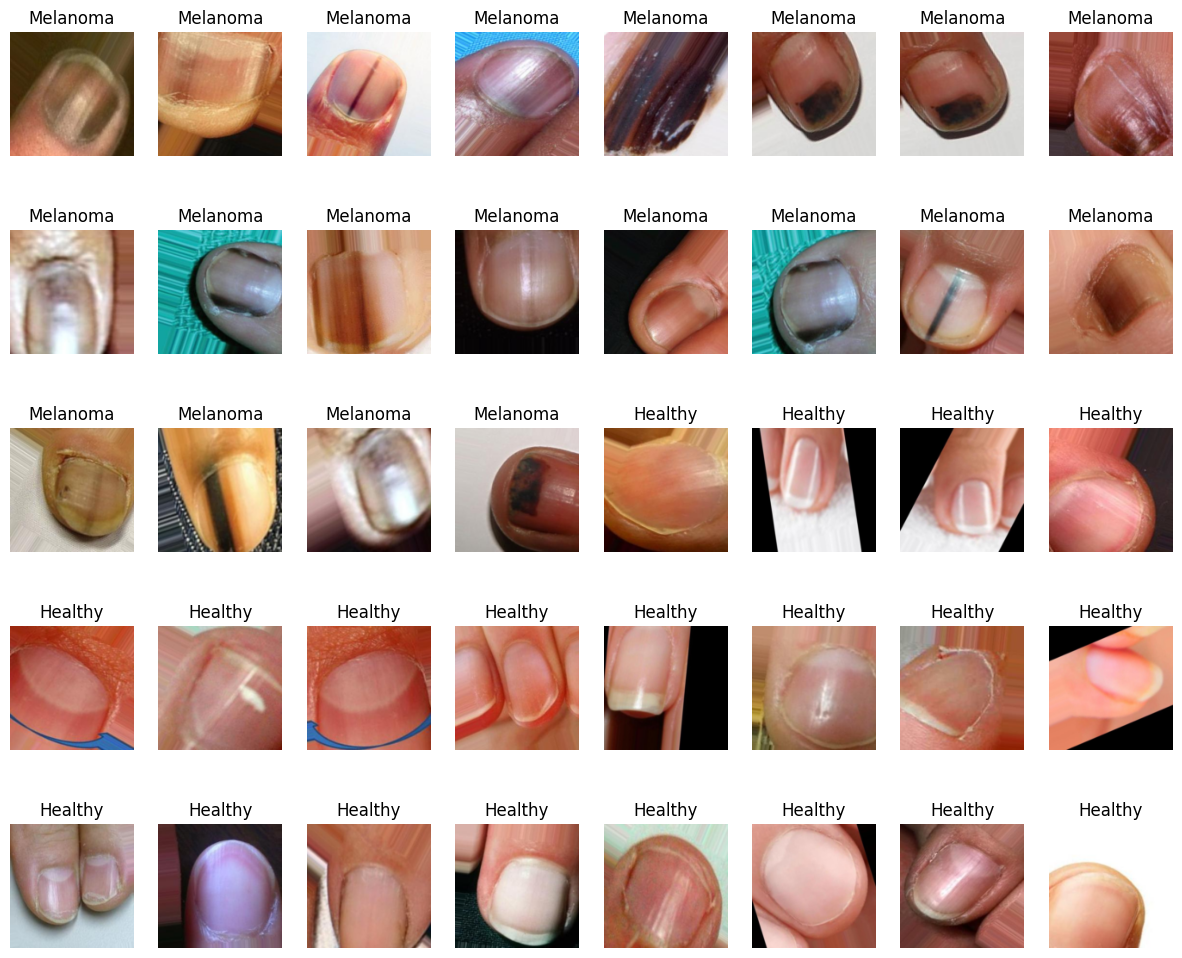

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, melanoma_dir, healthy_dir, transform=None):
        """
        Args:
            melanoma_dir (string): Directory with melanoma images
            healthy_dir (string): Directory with healthy images
            transform (callable, optional): Optional transform to be applied on images
        """
        self.transform = transform
        
        # Get all image paths and labels
        melanoma_images = [(os.path.join(melanoma_dir, fname), 1) for fname in os.listdir(melanoma_dir) 
                          if fname.endswith(('.jpg', '.jpeg', '.png'))]
        healthy_images = [(os.path.join(healthy_dir, fname), 0) for fname in os.listdir(healthy_dir)
                         if fname.endswith(('.jpg', '.jpeg', '.png'))]
        
        self.image_paths = melanoma_images + healthy_images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def show_images(dataset, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = max(1, int(len(dataset) / num_samples))
    
    count = 0
    for i in range(0, len(dataset), idx):
        if count >= num_samples:
            break
        img, label = dataset[i]
        plt.subplot(int(num_samples/cols) + 1, cols, count + 1)
        plt.imshow(to_pil_image(img))
        plt.title('Melanoma' if label == 1 else 'Healthy')
        plt.axis('off')
        count += 1

# Define transforms using transforms.Compose
transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.ToTensor()
])

# Create dataset
melanoma_dir = "Dataset/New/Augmented/NailMelanoma"
healthy_dir = "Dataset/New/Augmented/Healthy"
dataset = CustomImageDataset(
    melanoma_dir=melanoma_dir,
    healthy_dir=healthy_dir,
    transform=transform
)

# Show sample images
show_images(dataset)

# Print dataset info
print(f"Total images in dataset: {len(dataset)}")
print(f"Sample image shape: {dataset[0][0].shape}")

## **3. Patch Images**

In [6]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

# Run a quick test
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


In [8]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [9]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [10]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [11]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [12]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [13]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [14]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [15]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[ 0.1426, -0.2333, -0.2064, -0.1012,  1.2193, -0.3452, -0.4394, -0.2270,
          1.1285, -0.3841, -0.0250,  0.2445, -0.7257,  0.9748,  0.8321, -0.0340,
         -0.7464, -0.1185,  0.1279, -0.1269, -0.1474, -1.0545, -0.0522, -1.0531,
          0.7039,  0.4856,  0.1526,  0.1016,  0.9890, -0.2346,  0.2895,  0.0294,
          0.6183,  0.2090,  0.1836, -0.6534,  0.0838]],
       grad_fn=<AddmmBackward0>)

In [16]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [ ]:
import torch.optim as optim
import numpy as np

device = "cuda"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        # Something was strange when using this?
        # model.eval()
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
        print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

>>> Epoch 0 train loss:  1.1798558801412582
>>> Epoch 0 test loss:  0.7527363324165344
>>> Epoch 5 train loss:  0.6994462525844574
>>> Epoch 5 test loss:  0.6971497535705566
>>> Epoch 10 train loss:  0.6974099880456924
>>> Epoch 10 test loss:  0.7139401936531067
>>> Epoch 15 train loss:  0.6969516968727112
>>> Epoch 15 test loss:  0.6981142807006836


In [ ]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Actual classes tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')


In [26]:
model.history

AttributeError: 'ViT' object has no attribute 'history'